In [1]:
#Import packages
from datascience import *
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd
from matplotlib import patches

<table style="width: 100%;">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, EdX<br>
            Dr. Eric Van Dusen <br> 
            Peter Grinde-Hollevik<br>
            Akhil Venkatesh
        </p></td></tr>
</table>

   # Lecture Notebook 9.1: Constructing the MAC Curve for Methane Gas

## Learning objectives


* Understanding of how to construct the of The McKinsey Greenhouse Gas (GHG) Marginal Abatement Cost Curve (MAC).
* Understanding of how to compare different MAC curves across industries and regions.

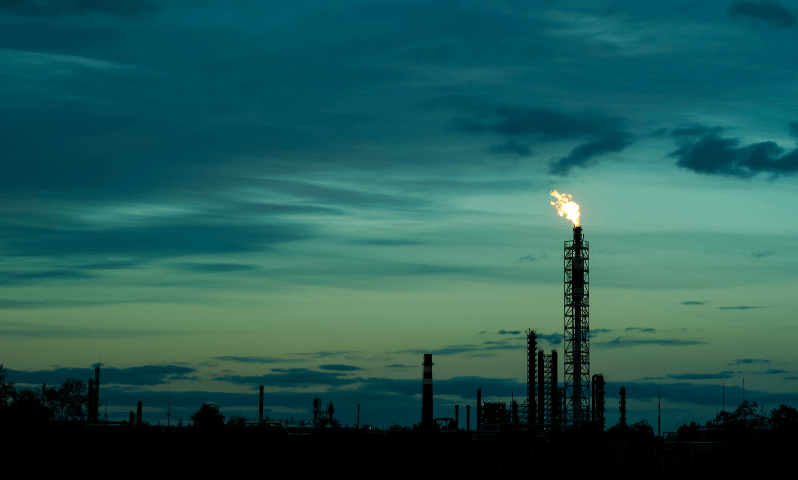

**This Notebook: Methane Illustration of Global MAC curve**

Please refer to the "Marginal Abatement Cost Curves" chapter for a thorough introduction to abatement curves. This is an empirical application of what you have learned in lecture and through your readings.

The data behind in the 2009 McKinsey Carbon Dioxide abatement curve is difficult to reproduce, and is out of date technologically.  For this empirical case study we are relying on a dataset published by the International Energy Association for methane emissions from the oil and gas sector.  One important starting point is that Methane is more powerful than CO2 in trapping heat in the atmosphere, 80 times more potent in the first 20 years and 20 times more powerful when average over 100 years. Methane emissions from the energy sector contribute 1/3 of all human caused methane emissions.  

**This dataset and documentation are from**: 

- Methane Emissions from Oil and Gas Report from IEA (https://www.iea.org/reports/methane-emissions-from-oil-and-gas)
- IEA Methane Tracker (2021) (https://www.iea.org/articles/methane-tracker-database).

Let's start off with a summary about global oil and gas methane emissions from their report:

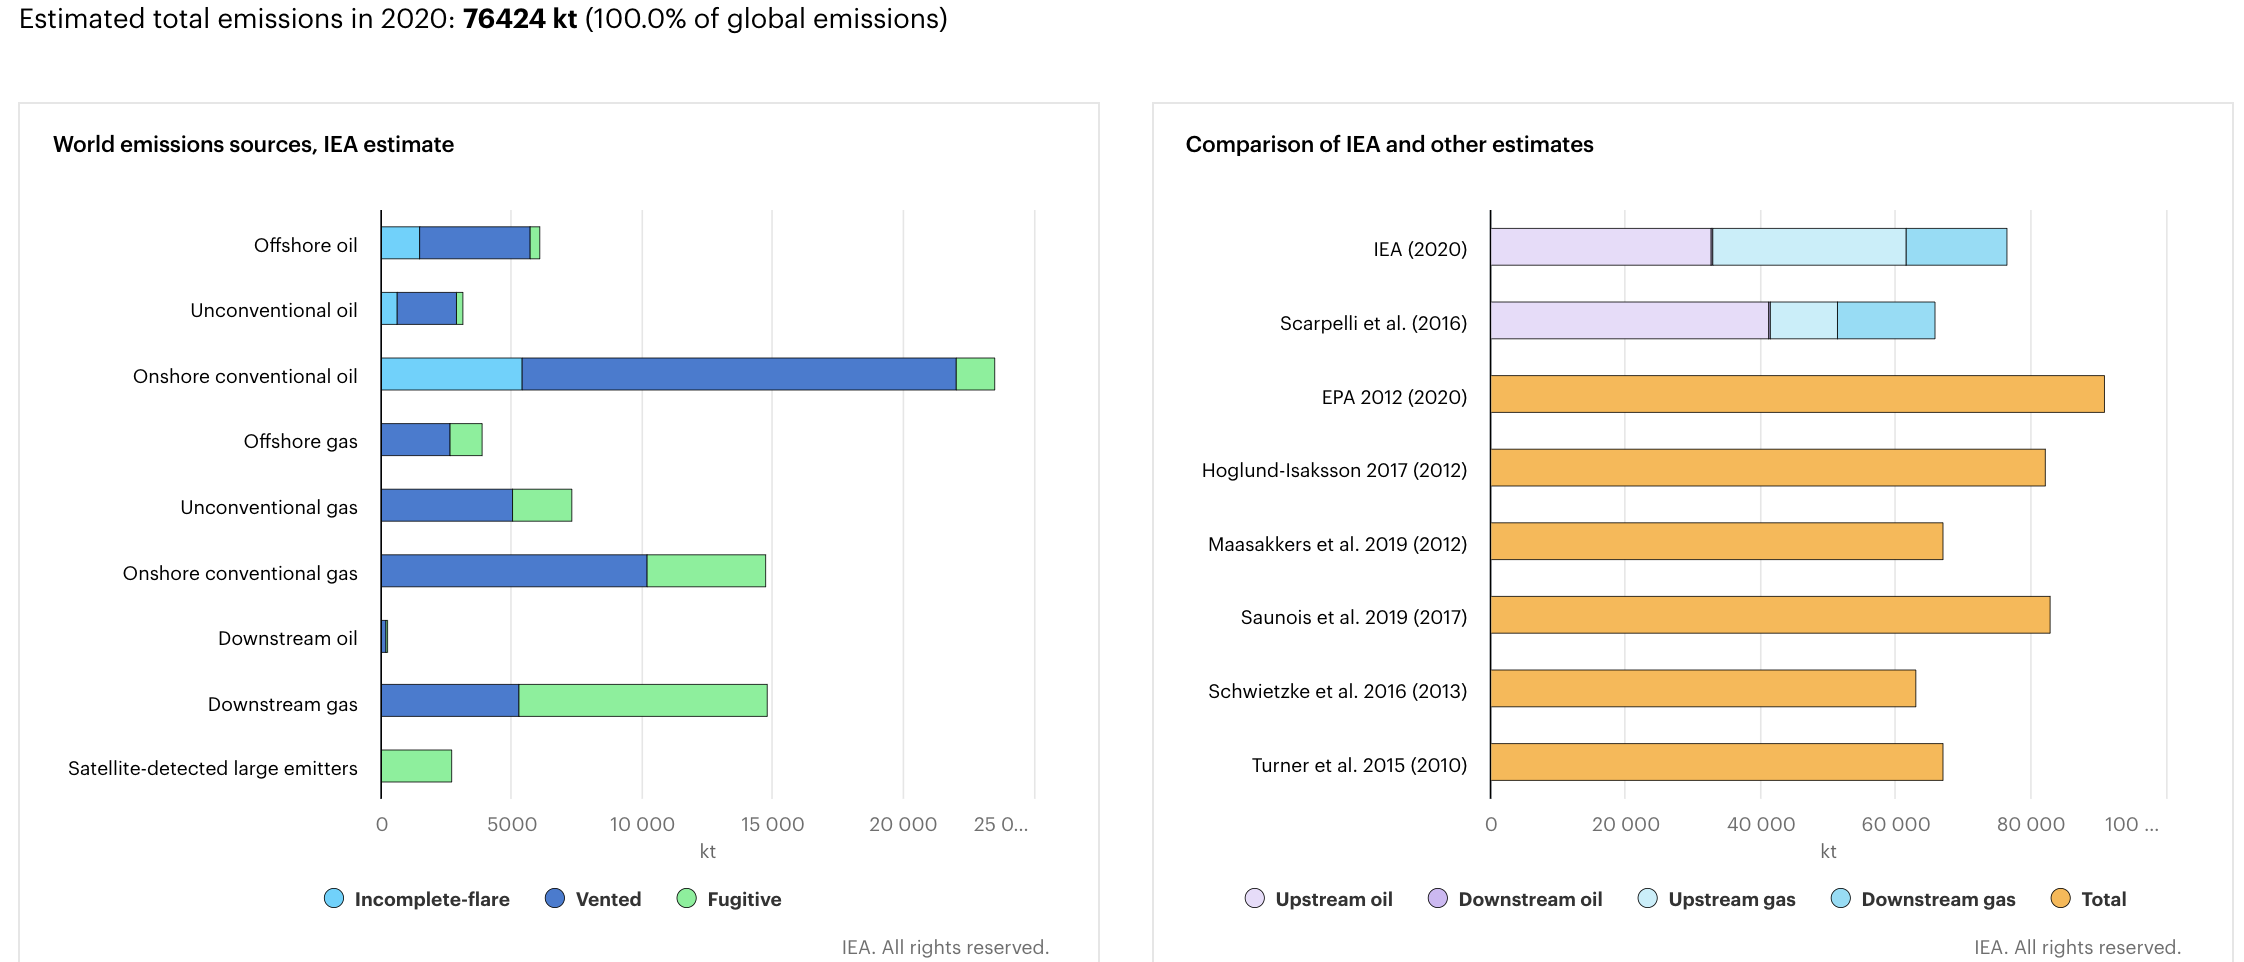

The chart on the left offers indications of where these methane emissions occur within the oil and gas industry.  The chart on the right indicates where the IEA estimates fall in respect to other recent studies.  This clearly illustrates the enormous potential of methane emission abatement in the world's oil and gas sector. With high abatement potential, it is important to understand the various abatement technologies and their costs. 

We start by importing a dataset on methane abatement from the International Environmental Agency (IEA): 

In [2]:
abatement_table = Table.read_table("abatement_data.csv").where('Cost',are.between(-10.1,10)).where('Possible Savings', are.below(200)).drop('Emissions').relabel('Possible Savings', 'Abatement Potential').relabel('Cost','Abatement Cost')
abatement_table

Country,Region,Oil Gas,Production source,Upstream Downstream,Reason,Abatement technology,Abatement Potential,Abatement Cost
Japan,Asia Pacific,Gas,Onshore conventional gas,Upstream,Vented,Replace pumps,0.25,-6.2
Japan,Asia Pacific,Oil,Onshore conventional oil,Upstream,Vented,Blowdown capture,0,-6.18
Japan,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace with instrument air systems,0.02,-5.84
Japan,Asia Pacific,Oil,Offshore oil,Upstream,Vented,Replace with instrument air systems,0.01,-5.84
Japan,Asia Pacific,Gas,Downstream gas,Downstream,Vented,Replace with instrument air systems,0.62,-5.84
Japan,Asia Pacific,Oil,Offshore oil,Upstream,Vented,Replace compressor seal or rod,0,-5.58
Japan,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace compressor seal or rod,0,-5.58
Japan,Asia Pacific,Gas,Onshore conventional gas,Upstream,Vented,Blowdown capture,0.59,-5.57
India,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace with instrument air systems,2.75,-5.33
India,Asia Pacific,Gas,Downstream gas,Downstream,Vented,Replace with instrument air systems,0.91,-5.33


##### The Second column is Region. To begin with, let's select the Asia Pacific region.
The first MAC is drawn for the Asia Pacific region.  This is approximately 1/4 of all emissions.  Later, our analysis for the Asia Pacific Region can compared to North America.

In [3]:
selection = 'Asia Pacific'
abatement_table_ap = abatement_table.where('Region', selection)
abatement_table_ap

Country,Region,Oil Gas,Production source,Upstream Downstream,Reason,Abatement technology,Abatement Potential,Abatement Cost
Japan,Asia Pacific,Gas,Onshore conventional gas,Upstream,Vented,Replace pumps,0.25,-6.2
Japan,Asia Pacific,Oil,Onshore conventional oil,Upstream,Vented,Blowdown capture,0,-6.18
Japan,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace with instrument air systems,0.02,-5.84
Japan,Asia Pacific,Oil,Offshore oil,Upstream,Vented,Replace with instrument air systems,0.01,-5.84
Japan,Asia Pacific,Gas,Downstream gas,Downstream,Vented,Replace with instrument air systems,0.62,-5.84
Japan,Asia Pacific,Oil,Offshore oil,Upstream,Vented,Replace compressor seal or rod,0,-5.58
Japan,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace compressor seal or rod,0,-5.58
Japan,Asia Pacific,Gas,Onshore conventional gas,Upstream,Vented,Blowdown capture,0.59,-5.57
India,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace with instrument air systems,2.75,-5.33
India,Asia Pacific,Gas,Downstream gas,Downstream,Vented,Replace with instrument air systems,0.91,-5.33


#### Plotting Functions
Building the MAC requires some data manipulations to build this specific visualization.  The first is that the width of the columns will be the quantity of abatement.  The height ( whether positive or negative) will be the cost.  

For drawing the plot we need to actually find the middle point in each column so that we place each abatement technology at the right place on the MAC. The seconds part runs the function on our x and y axis.

In [4]:
# Making columnn widths for the Asia Pacific _ap Region
def find_x_pos(widths):
    cumulative_widths = [0]
    cumulative_widths.extend(np.cumsum(widths))
    half_widths = [i/2 for i in widths]
    x_pos = []
    for i in range(0, len(half_widths)):
        x_pos.append(half_widths[i] + cumulative_widths[i])
    return x_pos

#Prepare the data for plotting
width_group = abatement_table_ap.column('Abatement Potential')
height_group = abatement_table_ap.column('Abatement Cost')
new_x_group = find_x_pos(width_group)

### Policy Analysis Tool
Now lets add a tool in to see the effects of a tax.  With the following function, we introduce level of taxation to measure the total abatement outcome later.

In [5]:
def methane_tax(tax, table):
    if tax < min(table.column('Abatement Cost')):
        print("No Abatement")
    else:
        abatement = table.where('Abatement Cost', are.below_or_equal_to(tax))
        total_abatement = sum(abatement.column('Abatement Potential'))
        abatement_technologies = abatement.column('Abatement technology')
        
        print('Total Abatement (kt CH4): ', np.round(total_abatement,2))
        print("")

#### Plot the graph, with tax line
The next function takes the methane_tax function and does plots all the possible abatement opportunities. 

Try to understand what each "plt" part does if you're interested!

Methane Tax ($/MBtu): $4
Total Abatement (kt CH4):  4579.4



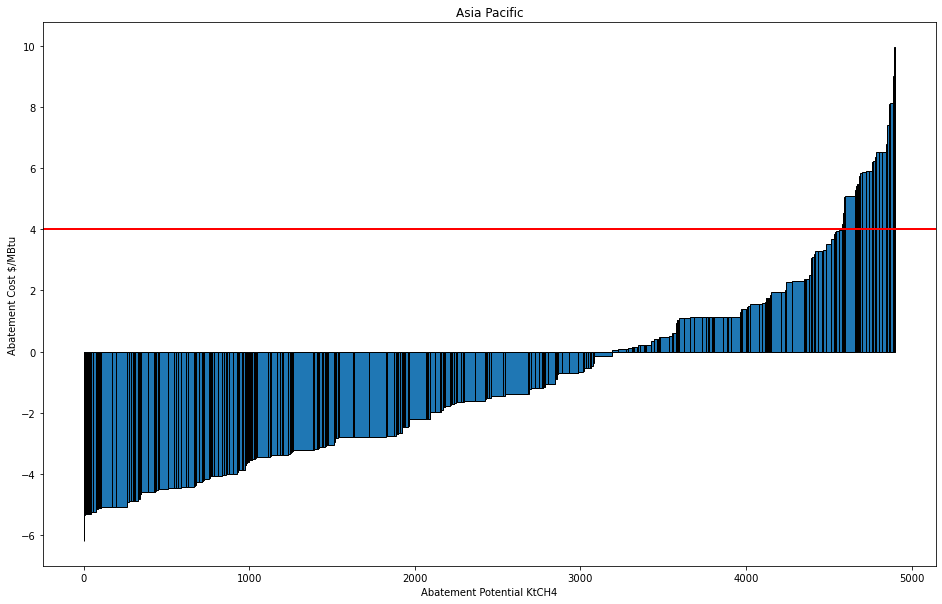

In [6]:
def group_plot(tax):
    print(f"Methane Tax ($/MBtu): ${tax}")
    methane_tax(tax, abatement_table_ap)
    plt.figure(figsize=(16,10))
    plt.bar(new_x_group, height_group,width=width_group,edgecolor = 'black')
    plt.title(selection)
    plt.xlabel('Abatement Potential KtCH4')
    plt.ylabel('Abatement Cost $/MBtu')
    plt.axhline(y=tax, color='r',linewidth = 2)
    
group_plot(4)

This is an applied MAC for Methane in Asia Pacific. 


Let's make the plot even more instructive by creating a color mapping of the different abatement technologies.
The solution to this is giving each a different color from a Python dictionary.

In [7]:
#Prepare data for plotting (second round)
width = abatement_table_ap.column('Abatement Potential')
height = abatement_table_ap.column('Abatement Cost')
new_x = find_x_pos(width)

#Let's give each type of technology a different color!
abatement_colors_dict = {}
count = 0
colors = ['#EC5F67', '#F29056', '#F9C863', '#99C794', '#5FB3B3', '#6699CC', '#C594C5','#85E827','#F165FD','#1F9F7F','#945CF8','#ff3a1d','#2a8506']
for i in set(abatement_table_ap['Abatement technology']):
    abatement_colors_dict[i] = colors[count]
    count += 1

colors_mapped = list(pd.Series(abatement_table_ap['Abatement technology']).map(abatement_colors_dict))
abatement_table_ap = abatement_table_ap.with_column('Color', colors_mapped)

Methane Tax: $3
Total Abatement (kt CH4):  4392.6



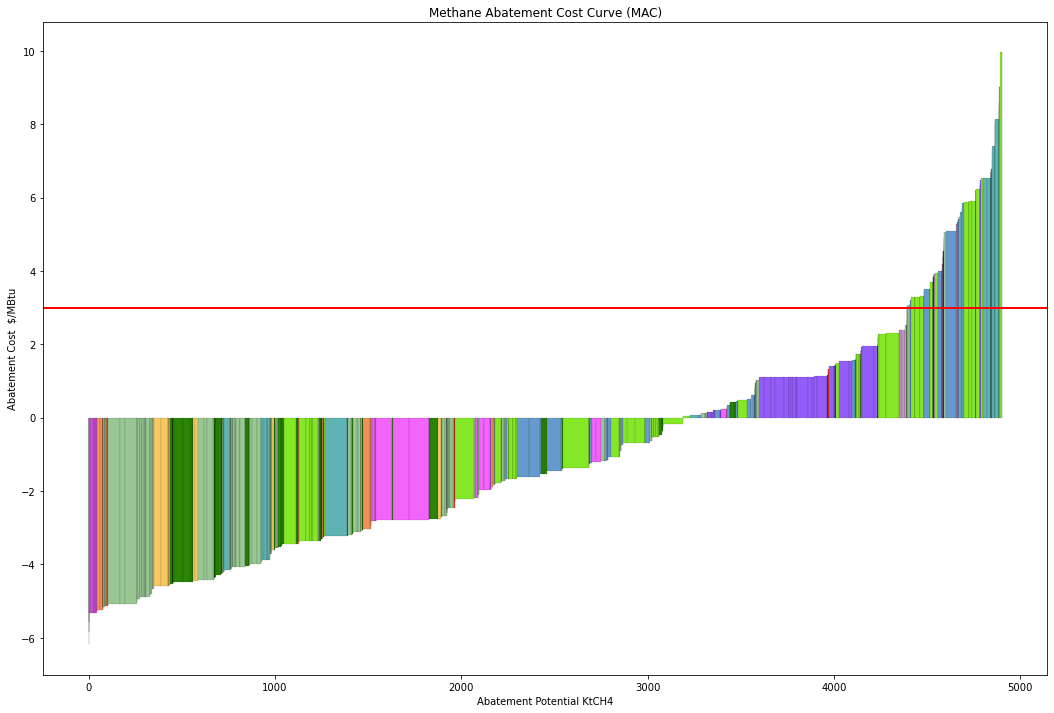

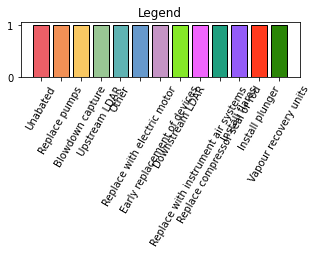

In [8]:
#The Methane curve plot - function!
def mckinsey_curve(tax, abatement_table):
    print(f"Methane Tax: ${tax}")
    methane_tax(tax, abatement_table_ap)
    plt.figure(figsize=(18,12))
    plt.bar(new_x, height, width=width, linewidth=0.1, color=abatement_table['Color'], edgecolor = "black")
    plt.title('Methane Abatement Cost Curve (MAC)')
    plt.xlabel('Abatement Potential KtCH4')
    plt.ylabel('Abatement Cost  $/MBtu')
    plt.axhline(y=tax, color='r', linewidth = 2)

    plt.figure(figsize=(5,1))
    plt.bar(abatement_colors_dict.keys(), 1, color = abatement_colors_dict.values())
    plt.xticks(rotation=60)
    plt.title('Legend')
    
mckinsey_curve(3, abatement_table_ap)

#### Color MAC plot for Asia Pacific Region
*Nice Plot!*   From here, we can differentiate the multiple methane abatement technologies on a cost basis, finding the most efficient ways of reducing methane emissions from gas production.

Looking at the Asia Region we can see that most of the opportunities on this graph have a negative cost- meaning that it makes economic sense to make the technological improvements.

We also observe the result of introducing a tax: With a tax of $3 per ton, we expect the total abatement to be almost 4300 tons within this industry.

### Now, repeating the process for North America:

Methane Tax: $3
Total Abatement (kt CH4):  4392.6



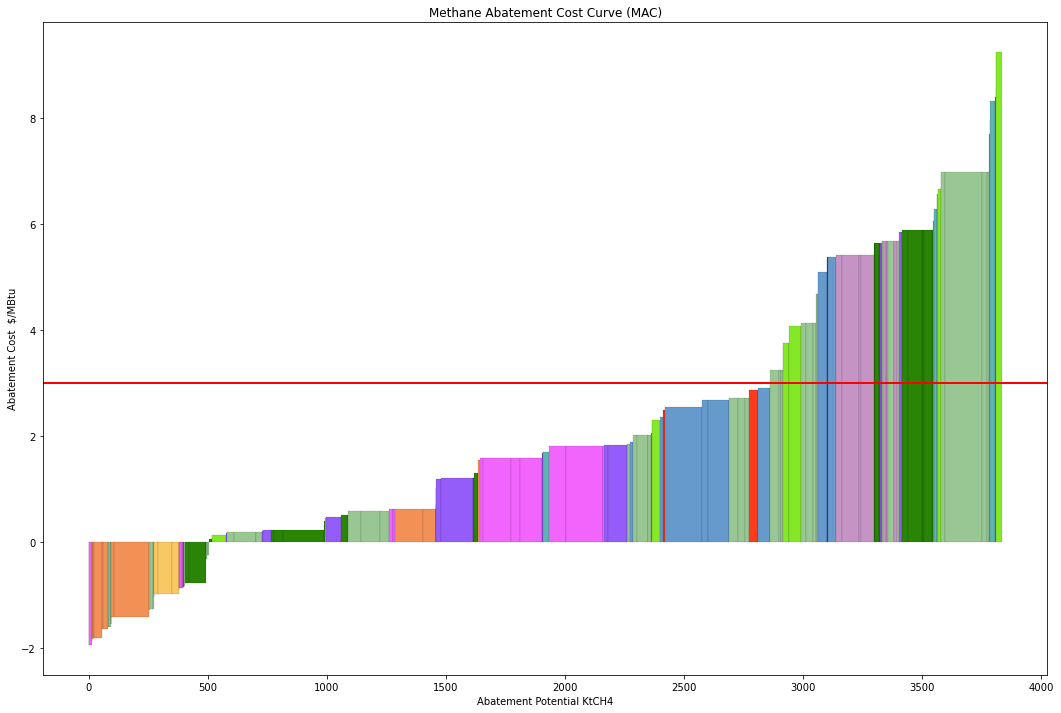

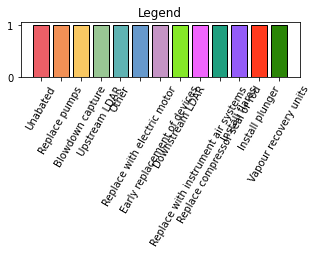

In [9]:
selection = 'North America'
abatement_table_us = abatement_table.where('Region', selection)
abatement_table_us

#Prepare data for plotting (North America. _us)
width = abatement_table_us.column('Abatement Potential')
height = abatement_table_us.column('Abatement Cost')
new_x = find_x_pos(width)

colors_mapped = list(pd.Series(abatement_table_us['Abatement technology']).map(abatement_colors_dict))
abatement_table_us = abatement_table_us.with_column('Color', colors_mapped)

mckinsey_curve(3, abatement_table_us)

### Finally, lets build the table for the Global emissions (all regions) :

Methane Tax: $3
Total Abatement (kt CH4):  4392.6



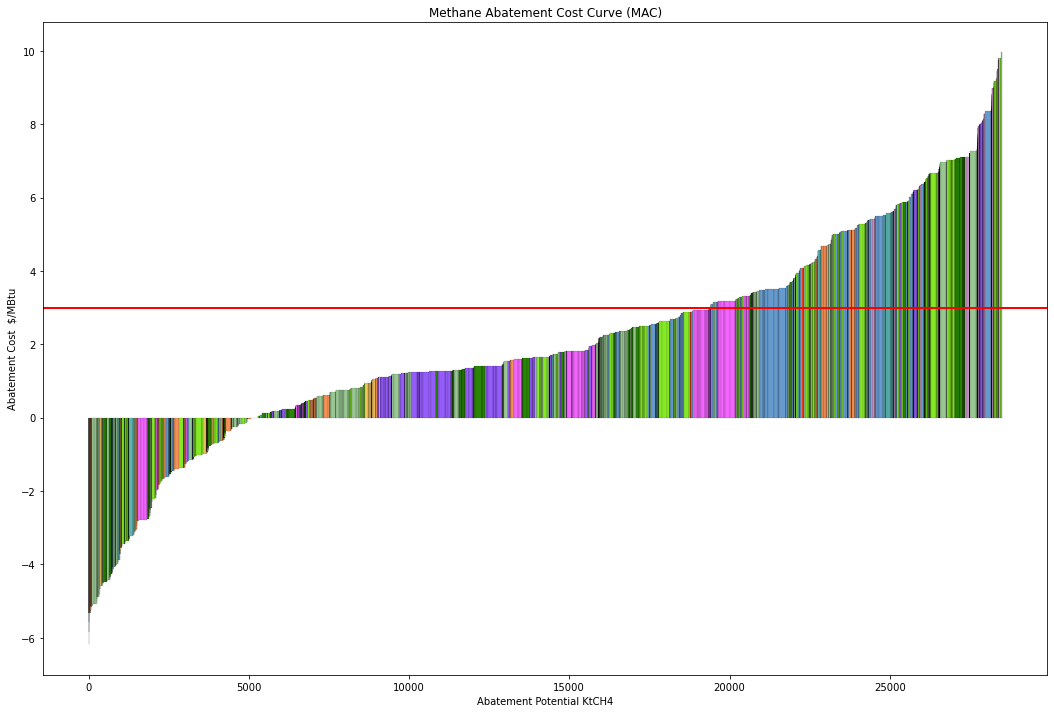

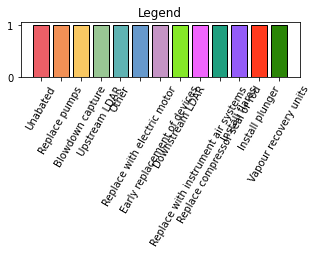

In [10]:
abatement_table = Table.read_table("abatement_data.csv").where('Cost',are.between(-10.1,10)).where('Possible Savings', are.below(200)).drop('Emissions').relabel('Possible Savings', 'Abatement Potential').relabel('Cost','Abatement Cost')
abatement_table

width = abatement_table.column('Abatement Potential')
height = abatement_table.column('Abatement Cost')
new_x = find_x_pos(width)

colors_mapped = list(pd.Series(abatement_table['Abatement technology']).map(abatement_colors_dict))
abatement_table = abatement_table.with_column('Color', colors_mapped)

mckinsey_curve(3, abatement_table)